# **Project: Predicting Stock Prices using Algorithms**

### **Disclaimer** 
**This project is created fully for informational and educational purposes. Predicting the stock market price is a highly complex task that involves<br> great financial risks, and past performance is not indicative of future results. Please consult with a qualified financial advisor before making any<br> form of investment decisions, and I strongly discourage you from using my machine learning model as a basis for your financial decisions. <br>
<br>
Furthermore, all data gathered for this project's use is obtained from open-source websites. <br>No information used in this project is obtained through unauthorized means.**

## **Phase Three: Creating Machine Learning Model**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# train test split
from sklearn.model_selection import train_test_split

# encoding
from sklearn.preprocessing import OneHotEncoder
from category_encoders import OrdinalEncoder, BinaryEncoder

# stationarity test
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# column transformer & pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# cross validation
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, RandomizedSearchCV

# feature selection
from sklearn.feature_selection import SelectKBest

# algorithm
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# metric
from sklearn.metrics import mean_absolute_error as mae, r2_score
from statsmodels.tools.eval_measures import rmse

# resampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline as imb_Pipeline

# ensemble models
from sklearn.ensemble import VotingRegressor, BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

# pickle
import pickle

# ignoring warnings
import warnings
warnings.filterwarnings('ignore')

### **Initial Dataset**

In [3]:
df = pd.read_csv('data/MSFT_data.csv', parse_dates=['Date'])
df

,Date,GDP_Growth_Rate,Inflation_Rate,NASDAQ_Close,NASDAQ_Volume,Revenue,EPS,FCF,MSFT_Volume,MSFT_Close
0,2021-01-01,1.542792,1.399770,12888.280273,4.815840e+09,3.715400e+10,1.84,2.277000e+10,20942100.0,217.042542
1,2021-01-02,1.542792,1.399770,12888.280273,4.815840e+09,3.715400e+10,1.84,2.277000e+10,20942100.0,217.042542
2,2021-01-03,1.542792,1.399770,12888.280273,4.815840e+09,3.715400e+10,1.84,2.277000e+10,20942100.0,217.042542
3,2021-01-04,1.542792,1.399770,12698.450195,6.636170e+09,3.715400e+10,1.84,2.277000e+10,37130100.0,212.426926
4,2021-01-05,1.542792,1.399770,12818.959961,6.971860e+09,3.715400e+10,1.84,2.277000e+10,23823000.0,212.631821
...,...,...,...,...,...,...,...,...,...,...
906,2023-06-26,0.496812,2.969178,13335.780273,4.430600e+09,5.274700e+10,2.20,3.964800e+10,21520600.0,327.905762
907,2023-06-27,0.496812,2.969178,13555.669922,5.053660e+09,5.274700e+10,2.20,3.964800e+10,24354100.0,333.863159
908,2023-06-28,0.496812,2.969178,13591.750000,4.533270e+09,5.274700e+10,2.20,3.964800e+10,20259500.0,335.140442
909,2023-06-29,0.496812,2.969178,13591.330078,4.388140e+09,5.274700e+10,2.20,3.964800e+10,16997000.0,334.342102


### **1. Exploratory Data Analysis**

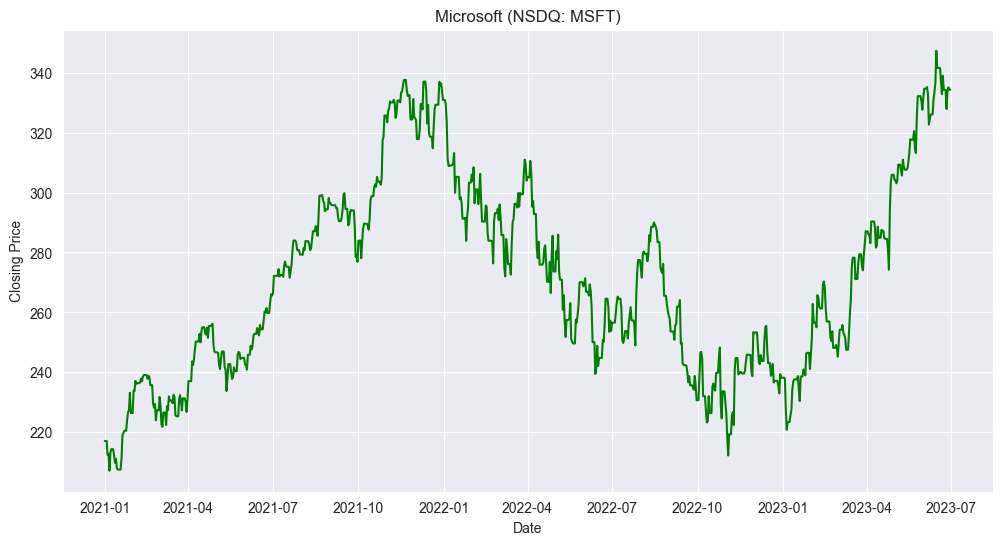

In [4]:
plt.figure(figsize=(12,6))
sns.set_style('darkgrid')
sns.lineplot(data=df, x='Date', y='MSFT_Close', color='g')
plt.xticks()
plt.title('Microsoft (NSDQ: MSFT)')
plt.ylabel('Closing Price');

**Insights:**
1. The stock MSFT has been relatively bullish (on an upwards trend) since January 2021.
2. MSFT stock experienced a dip on the year 2022.

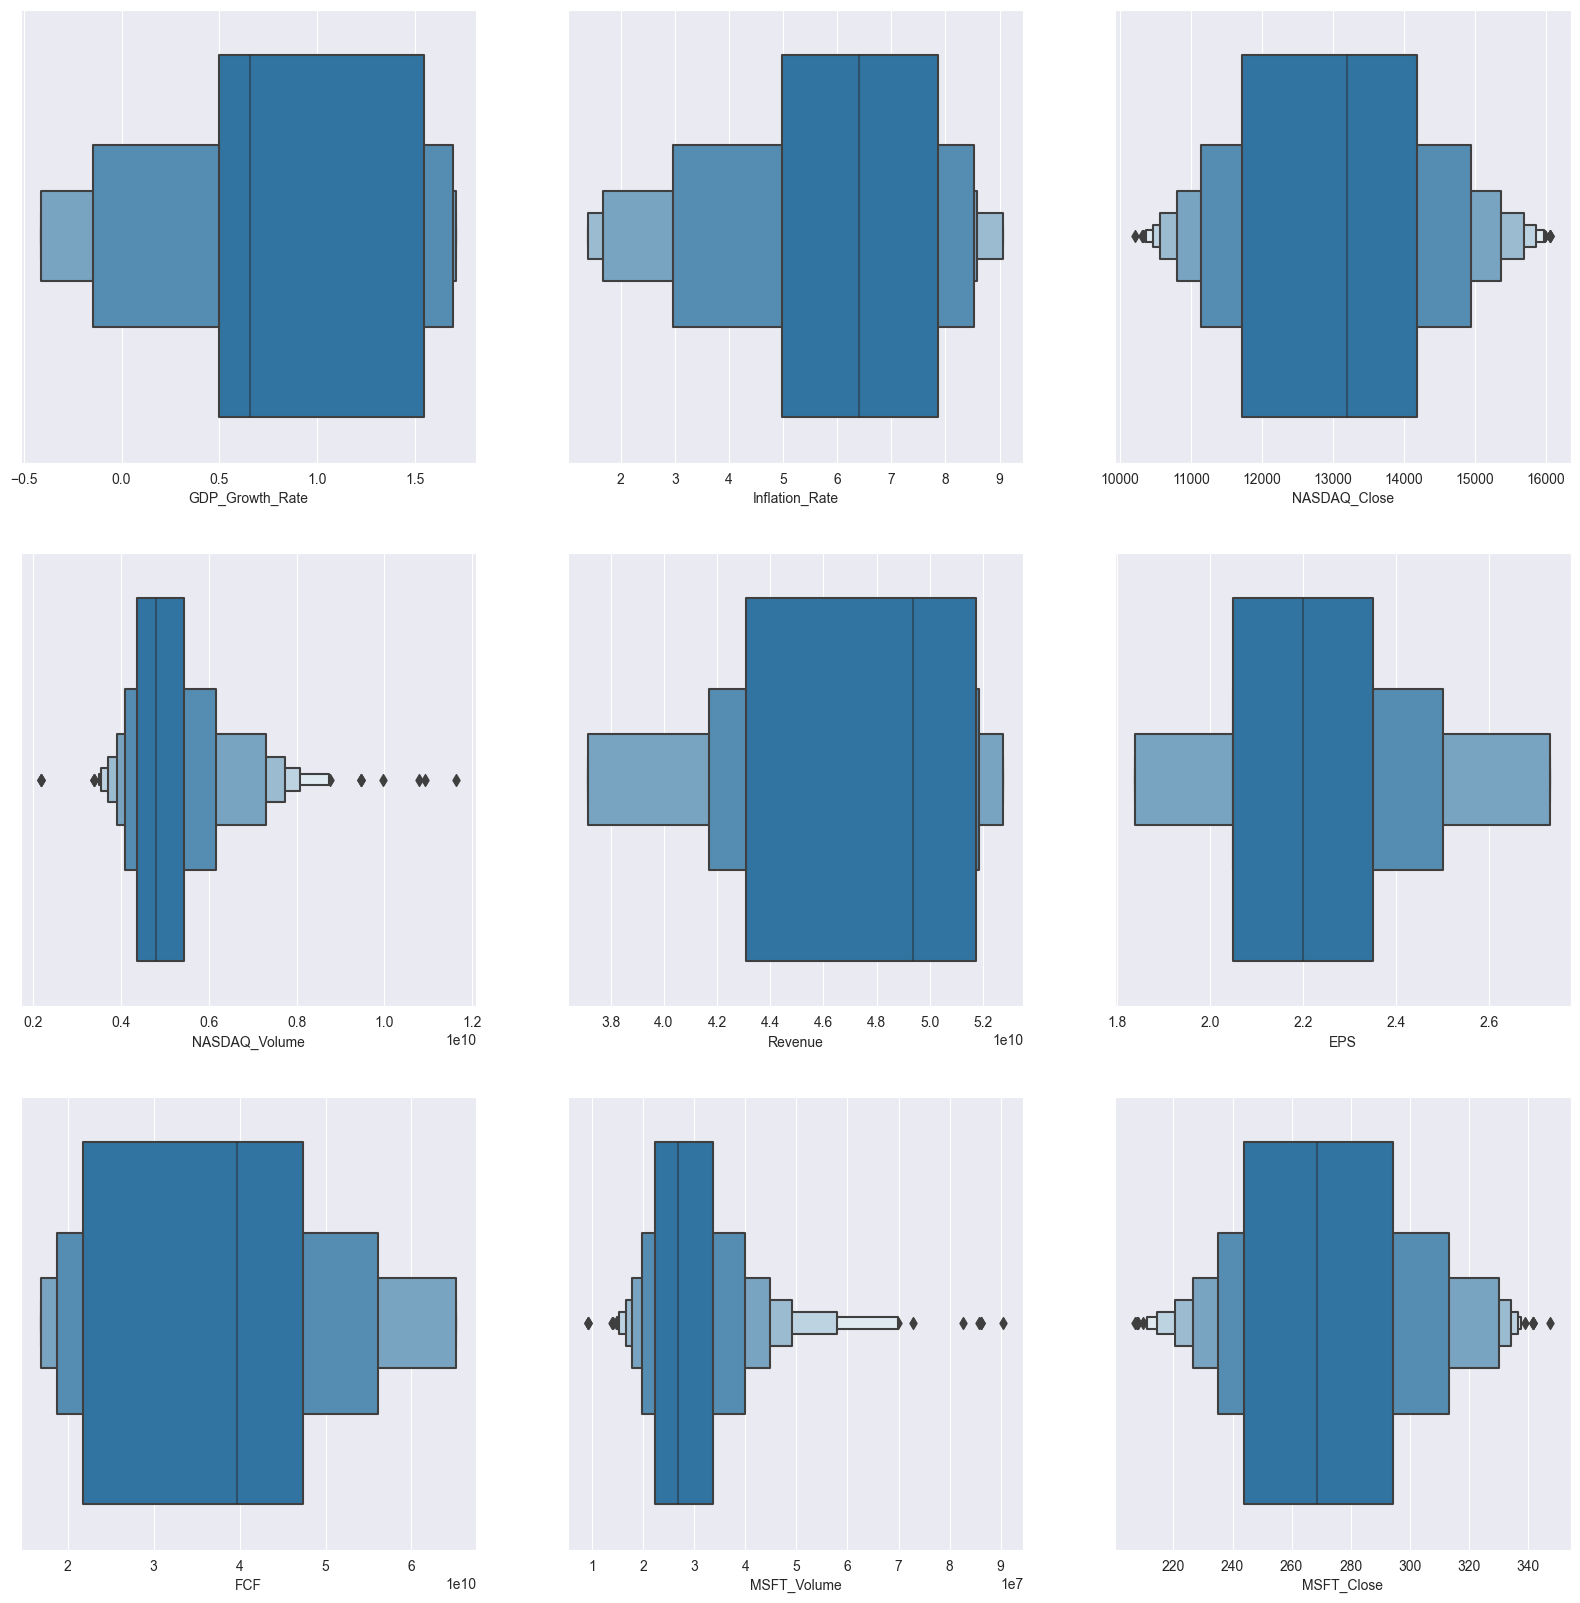

In [5]:
pltnum = 1
plt.figure(figsize=(20,20))
for column in df.describe(exclude=['datetime']).columns:
    plt.subplot(3,3,pltnum)
    sns.boxenplot(data=df, x=column)
    pltnum += 1

**Insight:** Majority of the data are not normally distributed.

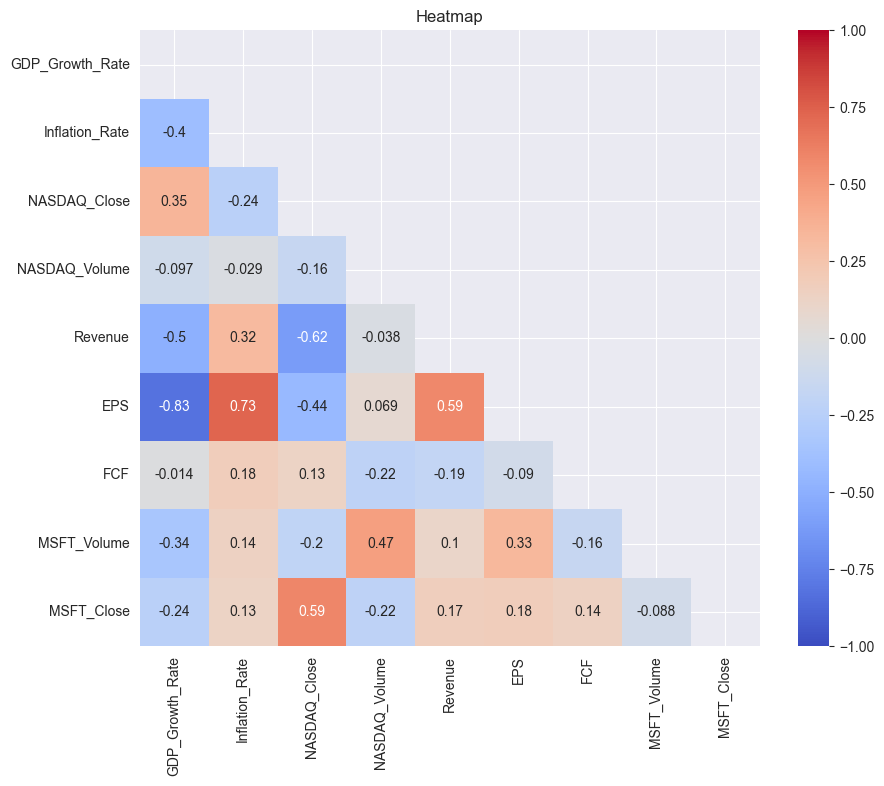

In [6]:
matrix = df.corr(numeric_only=True, method='spearman')
plt.figure(figsize=(10,8))
plt.title('Heatmap')
sns.set_style('white')
sns.heatmap(data=matrix,
            annot=True, # Annotates the numbers in the heatmap
            cmap= 'coolwarm', # Changes color of heatmap. Colors given in the seaborn function.
            center=0, # Becomes white the closer the value is to 0.
            mask=np.triu(matrix), # Removes the "double" values in the heatmap.
            vmin = -1, # At value = -1, color is Blue.
            vmax = 1 # At value = 1, color is Red.
            );

**Insight:** Most of the features generally have a weak correlation to the closing price of MSFT, except the closing index of NASDAQ.

### **2. Feature Engineering**
We can engineer the feature 'Date' and create new columns:
- Year
- Quarter
- Month
- Day of the week (Mon, Tue, Wed), where Mon = 1, Tue = 2, etc.

In [7]:
# date engineering
def date_engineering(info):
    info['Year'] = info['Date'].dt.year
    info['Quarter'] = info['Date'].dt.quarter
    info['Month'] = info['Date'].dt.month
    info['Day_of_Week'] = info['Date'].dt.day_of_week + 1
    
    return info
    
date_engineering(df)

,Date,GDP_Growth_Rate,Inflation_Rate,NASDAQ_Close,NASDAQ_Volume,Revenue,EPS,FCF,MSFT_Volume,MSFT_Close,Year,Quarter,Month,Day_of_Week
0,2021-01-01,1.542792,1.399770,12888.280273,4.815840e+09,3.715400e+10,1.84,2.277000e+10,20942100.0,217.042542,2021,1,1,5
1,2021-01-02,1.542792,1.399770,12888.280273,4.815840e+09,3.715400e+10,1.84,2.277000e+10,20942100.0,217.042542,2021,1,1,6
2,2021-01-03,1.542792,1.399770,12888.280273,4.815840e+09,3.715400e+10,1.84,2.277000e+10,20942100.0,217.042542,2021,1,1,7
3,2021-01-04,1.542792,1.399770,12698.450195,6.636170e+09,3.715400e+10,1.84,2.277000e+10,37130100.0,212.426926,2021,1,1,1
4,2021-01-05,1.542792,1.399770,12818.959961,6.971860e+09,3.715400e+10,1.84,2.277000e+10,23823000.0,212.631821,2021,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
906,2023-06-26,0.496812,2.969178,13335.780273,4.430600e+09,5.274700e+10,2.20,3.964800e+10,21520600.0,327.905762,2023,2,6,1
907,2023-06-27,0.496812,2.969178,13555.669922,5.053660e+09,5.274700e+10,2.20,3.964800e+10,24354100.0,333.863159,2023,2,6,2
908,2023-06-28,0.496812,2.969178,13591.750000,4.533270e+09,5.274700e+10,2.20,3.964800e+10,20259500.0,335.140442,2023,2,6,3
909,2023-06-29,0.496812,2.969178,13591.330078,4.388140e+09,5.274700e+10,2.20,3.964800e+10,16997000.0,334.342102,2023,2,6,4


### **3. Defining Features (X) and Target (y)**

In [8]:
x = df.drop(columns=['MSFT_Close','Date'])
y = df['MSFT_Close']
display(x.head())
y.head()

,GDP_Growth_Rate,Inflation_Rate,NASDAQ_Close,NASDAQ_Volume,Revenue,EPS,FCF,MSFT_Volume,Year,Quarter,Month,Day_of_Week
0,1.542792,1.39977,12888.280273,4.815840e+09,3.715400e+10,1.84,2.277000e+10,20942100.0,2021,1,1,5
1,1.542792,1.39977,12888.280273,4.815840e+09,3.715400e+10,1.84,2.277000e+10,20942100.0,2021,1,1,6
2,1.542792,1.39977,12888.280273,4.815840e+09,3.715400e+10,1.84,2.277000e+10,20942100.0,2021,1,1,7
3,1.542792,1.39977,12698.450195,6.636170e+09,3.715400e+10,1.84,2.277000e+10,37130100.0,2021,1,1,1
4,1.542792,1.39977,12818.959961,6.971860e+09,3.715400e+10,1.84,2.277000e+10,23823000.0,2021,1,1,2


0    217.042542
1    217.042542
2    217.042542
3    212.426926
4    212.631821
Name: MSFT_Close, dtype: float64

### **4. Data Splitting**
We will split the data into two:
- **the training set**, the data which the model will learn from, and
- **the testing set**, the data to test the accuracy of our model.

In [9]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2,
    random_state=42
)

### **5. Preprocessing**
In preprocessing, we will be handling:
1. **Missing Values.** Since there are no missing values, we can skip this process.
2. **Encoding.** Since there are no categorical features, we can also skip this process.
3. **Scaling.** Since the range of numerical values are extremely large, we will be scaling them to improve our model's accuracy.
    - Robust Scaling will be required for all numerical columns, except columns **Quarter and Day_of_Week**.

In [10]:
# scaled features
columns = x.columns.drop(['Quarter','Day_of_Week'])

# scaler
transformer = ColumnTransformer([
    ('robust', RobustScaler(), columns)
], remainder='passthrough')
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('robust', RobustScaler(),
                                 Index(['GDP_Growth_Rate', 'Inflation_Rate', 'NASDAQ_Close', 'NASDAQ_Volume',
       'Revenue', 'EPS', 'FCF', 'MSFT_Volume', 'Year', 'Month'],
      dtype='object'))])

### **6. Model Cross-Validation**

There are several algorithms that we will be using for our machine learning model. <br>
We will test each of these and determine which one is the most accurate algorithm.
1. Ridge
2. Lasso
3. DecisionTreeRegressor
4. KNeighborsRegressor
5. Ensemble Models:
    - RandomForestRegressor
    - BaggingRegressor
    - VotingRegressor
    - AdaBoostRegressor
    - XGBoostRegressor
    - SVRegression

The metrics we will be using to test our algorithms will be:
1. Mean Absolute Error (MAE), used to indicate the **difference in price** between our predicted values and the actual values.
2. Root Mean Squared Error (RMSE), used to indicate the **magnitude of error** in our regression model.
3. R-squared (R2 Score), used to determine the **overall fit** of our regression model.

In [11]:
# base models
ridge = Ridge(random_state=42)
lasso = Lasso(random_state=42)
tree = DecisionTreeRegressor(random_state=42)
knn = KNeighborsRegressor()

# ensemble models
rf = RandomForestRegressor(random_state=42)
adb = AdaBoostRegressor(random_state=42)
xgb = XGBRegressor()
svr = SVR()

voting = VotingRegressor([
    ('reg1', ridge),
    ('reg2', lasso),
    ('reg3', tree),
    ('reg4', knn)
])

bagging = BaggingRegressor(
    random_state = 42,
    estimator = knn
)

In [12]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
list_models = [ridge, lasso, tree, knn, rf, adb, xgb, voting, bagging, svr]
list_metrics = ['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']

for metric in list_metrics:
    
    cv_mean = []
    cv_std = []
    
    for model in list_models:
        
        model_pipe = Pipeline([
            ('preprocessing', transformer),
            ('modeling', model)
        ])
        
        model_cv = cross_val_score(
            estimator = model_pipe,
            X = x_train,
            y = y_train,
            cv = kfold,
            scoring = metric
        )
        
        cv_mean.append(model_cv.mean())
        cv_std.append(model_cv.std())
        
    df_cv = pd.DataFrame({
    'models':list_models,
    'mean':cv_mean,
    'std':cv_std,
    })
        
    print(f"Metric used: {metric}")
    display(df_cv.sort_values('mean', ascending=False))
    print('====================================')

Metric used: neg_mean_absolute_error


,models,mean,std
6,"XGBRegressor(base_score=None, booster=None, ca...",-2.538047,0.232967
4,RandomForestRegressor(random_state=42),-2.609903,0.262273
2,DecisionTreeRegressor(random_state=42),-2.864183,0.206081
7,"VotingRegressor(estimators=[('reg1', Ridge(ran...",-5.228872,0.220388
5,AdaBoostRegressor(random_state=42),-6.094490,0.136740
0,Ridge(random_state=42),-6.315448,0.219134
1,Lasso(random_state=42),-8.012098,0.363260
8,BaggingRegressor(estimator=KNeighborsRegressor...,-9.932553,0.368820
3,KNeighborsRegressor(),-9.962239,0.461153
9,SVR(),-20.998253,1.720045


Metric used: neg_root_mean_squared_error


,models,mean,std
4,RandomForestRegressor(random_state=42),-3.827399,0.404179
6,"XGBRegressor(base_score=None, booster=None, ca...",-4.071486,0.285844
2,DecisionTreeRegressor(random_state=42),-4.963484,0.230105
7,"VotingRegressor(estimators=[('reg1', Ridge(ran...",-6.477417,0.246591
5,AdaBoostRegressor(random_state=42),-7.494961,0.155062
0,Ridge(random_state=42),-7.765523,0.205324
1,Lasso(random_state=42),-9.808133,0.408613
8,BaggingRegressor(estimator=KNeighborsRegressor...,-12.815722,0.746055
3,KNeighborsRegressor(),-12.952558,0.707958
9,SVR(),-26.921908,1.801941


Metric used: r2


,models,mean,std
4,RandomForestRegressor(random_state=42),0.985807,0.003004
6,"XGBRegressor(base_score=None, booster=None, ca...",0.983985,0.002825
2,DecisionTreeRegressor(random_state=42),0.976442,0.002223
7,"VotingRegressor(estimators=[('reg1', Ridge(ran...",0.960012,0.001719
5,AdaBoostRegressor(random_state=42),0.946125,0.005921
0,Ridge(random_state=42),0.942291,0.005251
1,Lasso(random_state=42),0.908317,0.004277
8,BaggingRegressor(estimator=KNeighborsRegressor...,0.843303,0.013503
3,KNeighborsRegressor(),0.839664,0.015934
9,SVR(),0.310697,0.041742


The best model here is RandomForest, because:
1. It has the lowest errors compared to other models (lowest RMSE and relatively low MAE)
2. It has the highest R-squared value compared to other models (best-fit model)
<br>
We will now get to:

### **7. Hyperparameter Tuning**

#### **Modeling before Tuning**

In [13]:
# modeling
model_pretuned = Pipeline([
    ('preprocessing', transformer),
    ('modeling', rf)
])

# fitting
model_pretuned.fit(x_train, y_train)

# predicting
y_pred = model_pretuned.predict(x_test)

# metrics
print(f"MAE before tuning: {mae(y_pred, y_test)}")
print(f"RMSE before tuning: {rmse(y_pred, y_test)}")
print(f"R-squared before tuning: {r2_score(y_pred, y_test)}")

MAE before tuning: 2.0976832405465555
RMSE before tuning: 3.0819027830236423
R-squared before tuning: 0.9916727392312713


#### **Tuning Process**

In [14]:
params = {
    'modeling__n_estimators':[100,500],
    'modeling__max_depth':[5,10,20],
    'modeling__min_samples_split':[2,5,10],
    'modeling__min_samples_leaf':[1,2,4]
}
list_estimators = []

for metric in list_metrics:
    # define grid
    gridsearch = GridSearchCV(
        estimator = model_pretuned,
        param_grid = params,
        cv = kfold,
        n_jobs = -1,
        scoring = metric,
        verbose = 2
    )
    
    # fit
    gridsearch.fit(x_train, y_train)
    
    # append to list
    list_estimators.append(gridsearch.best_params_)
    
df_grid = pd.DataFrame(list_estimators, index=list_metrics)
df_grid = df_grid.reset_index().rename(columns={'index':'scoring'})
df_grid

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits


,scoring,modeling__max_depth,modeling__min_samples_leaf,modeling__min_samples_split,modeling__n_estimators
0,neg_mean_absolute_error,20,1,2,500
1,neg_root_mean_squared_error,20,1,2,500
2,r2,20,1,2,500


In [15]:
# tuned model
rf_tuned = RandomForestRegressor(random_state=42, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=500)

# pipeline
model_tuned = Pipeline([
    ('prep', transformer),
    ('model', rf_tuned)
])

# fit
model_tuned.fit(x_train, y_train)

# predict
y_pred = model_tuned.predict(x_test)

# metrics
print(f'MAE after tuning: {mae(y_pred, y_test)}')
print(f'RMSE after tuning: {rmse(y_pred, y_test)}')
print(f'R-squared after tuning: {r2_score(y_pred, y_test)}')

MAE after tuning: 2.1031702423911
RMSE after tuning: 3.0593291317993483
R-squared after tuning: 0.9917939267093623


**Results:**
1. MAE increases from **2.097** to **2.103** after tuning.
2. RMSE decreases from **3.081** to **3.059** after tuning.
3. R-squared increases from **0.9916** to **0.9917** after tuning.

#### **8. Feature Selection**

In [16]:
list_kval = range(1,len(x.columns)+1)
list_rmse = []
list_mae = []
list_r2 = []

for k in list_kval:
    # Selection Model
    select = SelectKBest(k=k)
    
    # Pipeline
    model_feat = Pipeline([
    ('prep', transformer),
    ('select', select),
    ('model', rf_tuned)
    ])
    
    # fit
    select.fit(x_train, y_train)

    # modeling
    model_feat.fit(x_train, y_train)
    
    # predicting
    y_pred_good = model_feat.predict(x_test)
    
    # rmse and r2
    rmse_val = rmse(y_pred_good, y_test)
    r2 = r2_score(y_pred_good, y_test)
    mae_val = mae(y_pred_good, y_test)
    
    # append to list
    list_rmse.append(rmse_val)
    list_mae.append(mae_val)
    list_r2.append(r2)
    
df_ktest = pd.DataFrame({
    'k':list_kval,
    'rmse':list_rmse,
    'mae':list_mae,
    'r2':list_r2
})
df_ktest

,k,rmse,mae,r2
0,1,22.428710,12.277504,0.483110
1,2,3.409754,2.241748,0.989871
2,3,3.358676,2.186777,0.990170
3,4,3.377725,2.305125,0.989980
4,5,3.627556,2.345438,0.988466
5,6,4.173888,2.400674,0.984721
6,7,3.945932,2.332073,0.986333
7,8,3.511619,2.216464,0.989174
8,9,3.311450,2.162172,0.990364
9,10,3.294230,2.145819,0.990468


**Results:**
1. MAE decreases from **2.103** to **2.027** after feature selection.
2. RMSE decreases from **3.059** to **3.032** after feature selection.
3. R-squared increases from **0.9917** to **0.9919** after feature selection.<br><br>
Therefore, **feature selection** using **SelectKFold** is required, at k-value = 11.<br>
We will check which features are selected.

### **8. Predicting to New Dataset**
Now that we have the best model, we will try and test our model on a new dataset, which consists of all the information above<br> for the time period July-August 2023.

#### **1. Actual vs Predicted**

In [57]:
df_new = pd.read_csv('data/MSFT_data_test.csv', parse_dates=['Date'])
df_new = date_engineering(df_new)
df_new = df_new.fillna(method='backfill')
df_new

,Date,GDP_Growth_Rate,Inflation_Rate,NASDAQ_Close,NASDAQ_Volume,Revenue,EPS,FCF,MSFT_Volume,MSFT_Close,Year,Quarter,Month,Day_of_Week
0,2023-07-01,0.496812,3.17778,13787.919922,4.661120e+09,5.285700e+10,2.46,5.947500e+10,26823800.0,339.820526,2023,3,7,6
1,2023-07-02,0.496812,3.17778,13787.919922,4.661120e+09,5.285700e+10,2.46,5.947500e+10,26823800.0,339.820526,2023,3,7,7
2,2023-07-03,0.496812,3.17778,13816.769531,2.902300e+09,5.285700e+10,2.46,5.947500e+10,12508700.0,337.275909,2023,3,7,1
3,2023-07-04,0.496812,3.17778,13816.769531,2.902300e+09,5.285700e+10,2.46,5.947500e+10,12508700.0,337.275909,2023,3,7,2
4,2023-07-05,0.496812,3.17778,13791.650391,5.339340e+09,5.285700e+10,2.46,5.947500e+10,18172400.0,337.435577,2023,3,7,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,2023-08-27,0.496812,3.17778,13590.650391,3.970060e+09,5.285700e+10,2.46,5.947500e+10,21684100.0,322.980011,2023,3,8,7
58,2023-08-28,0.496812,3.17778,13705.129883,3.666680e+09,5.285700e+10,2.46,5.947500e+10,14808500.0,323.700012,2023,3,8,1
59,2023-08-29,0.496812,3.17778,13943.759766,4.748180e+09,5.285700e+10,2.46,5.947500e+10,19284600.0,328.410004,2023,3,8,2
60,2023-08-30,0.496812,3.17778,14019.309570,4.364600e+09,5.285700e+10,2.46,5.947500e+10,15222100.0,328.790009,2023,3,8,3


In [26]:
# final model
model_final = Pipeline([
    ('prep', transformer),
    ('select', SelectKBest(k=11)),
    ('model', rf_tuned)
])

# fitting to model_final
model_final.fit(x_train, y_train)

# predict
y_pred_new = model_final.predict(df_new.drop(columns='MSFT_Close'))
error = y_pred_new - df_new['MSFT_Close']

# dataframe
df_testing = pd.DataFrame({
    'Date':df_new['Date'],
    'Predicted Price':y_pred_new,
    'Actual Price':df_new['MSFT_Close'],
    'Error':error
})
df_testing['Day_of_Week'] = df_testing['Date'].dt.day_of_week + 1
df_testing

,Date,Predicted Price,Actual Price,Error,Day_of_Week
0,2023-07-01,336.638597,339.820526,-3.181929,6
1,2023-07-02,336.638597,339.820526,-3.181929,7
2,2023-07-03,335.410853,337.275909,-1.865056,1
3,2023-07-04,335.410853,337.275909,-1.865056,2
4,2023-07-05,336.345979,337.435577,-1.089598,3
...,...,...,...,...,...
57,2023-08-27,329.153239,322.980011,6.173228,7
58,2023-08-28,334.590096,323.700012,10.890084,1
59,2023-08-29,336.247686,328.410004,7.837682,2
60,2023-08-30,336.591443,328.790009,7.801434,3


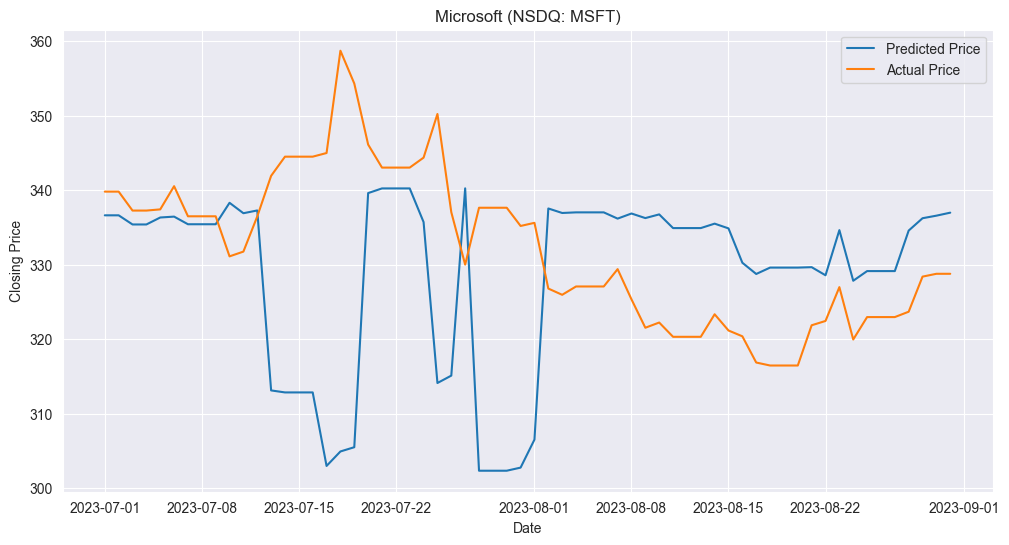

In [19]:
plt.figure(figsize=(12,6))
sns.set_style('darkgrid')
sns.lineplot(data=df_testing, x='Date', y='Predicted Price', label='Predicted Price')
sns.lineplot(data=df_testing, x='Date', y='Actual Price', label='Actual Price')
plt.xticks()
plt.title('Microsoft (NSDQ: MSFT)')
plt.ylabel('Closing Price');

**Insights:** 
1. The predicted prices are generally higher than the actual prices in August.
    - In July, however, the predicted prices are far lower than the actual prices.
2. The predicted price and the actual price follows a similar trend in August and on the first few weeks of July.
    - However, beginning from July 13, 2023, the predictions begin to fluctuate.

#### **2. Residual Plot**

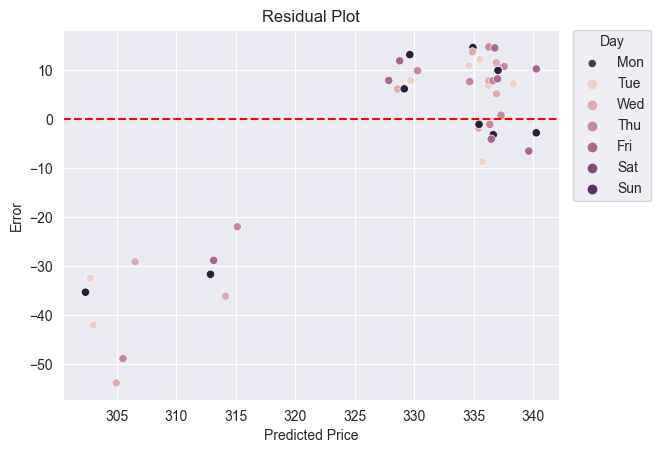

In [61]:
sns.scatterplot(data=df_testing, x='Predicted Price', y='Error', hue='Day_of_Week')
plt.axhline(y=0, color='r', linestyle='--')
plt.legend(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], bbox_to_anchor=(1.2,1.02), title='Day')
plt.title('Residual Plot');

**Insights:**
1. The errors are far greater at lower predicted prices (prices below $320).
2. At prices > $320, the errors become far more consistent and clustered.

### **9. Conclusion**

#### **Metrics Interpretation**
1. R-squared Score: 0.9919.
    - The model is capable of explaining 99.19% of the variance of the price.
    - This may be good in some cases. However, after testing with new data, it turns out that this high R-squared score <br>is an indication of the model being overfitted.
2. MAE: $2.027
    - The average absolute error produced by the model is $2.027.
    - This means that the model is relatively accurate, considering that MSFT prices are above $300.
3. RMSE: $3.032
    - The average prediction error produced by the model is $3.032.
    - The model is relatively accurate.


#### **Graphs Interpretation**
1. Actual vs Predicted
    - The model can capture the trend of the stock, except for certain periods in the new data. 
    - The model is highly inaccurate when it comes to predicting the correct price of the stock.
2. Residual Plot
    - The errors are far greater at prices below $320, irrespective of day of the week.
    - At prices above $320, the errors start to become more consistent, albeit still large.

#### **Can we use this model to predict stock prices?**
**No, this model cannot be used to predict stock prices.** While the model scores relatively well according to our metrics of evaluation, when applying the model to a new dataset, the model produces large errors, as well as fluctuating trends at certain periods of time. However, the model is capable of capturing the trends in the stock prices relatively accurately.

### **10. Recommendations**
There are some recommendations that can be made in order to further improve this model in the future:
1. **Addition of more features (factors) that influence stock market price.**
    - This model does not take into account many metrics that can influence stock market price.
        - Economic metrics: industry performance, employment rate, interest rate, etc
        - Non-economic metrics: investor sentiment, news related to the company, change in number of users (for MSFT), etc.
    - Web scraping techniques can be used to obtain these data.
2. **Collect more data on MSFT.**
    - The data is only obtained from the time period Jan 2021 - June 2023. 
    - To improve accuracy, we can try and extract more information from past years, maybe up to 2018.
3. **Experiment with different timescales.**
    - Most of the data obtained is obtained either in monthly or quarterly frequencies.
        - This may lead to inaccuracies in the model, as we are working with a model dealing with daily trends.
    - Future models can attempt to look at a larger timescale, for example, trends based on month. This way, the model may be more accurate.

### **Exporting Model and Streamlit**
To experiment with the model further, I created a Streamlit site that employs my model in predicting the stock prices of MSFT.<br>
The code for the Streamlit can be further observed in the file ***streamlit_msft.py***.

In [62]:
# pickle
import pickle

# best model
model_final = Pipeline([
    ('prep', transformer),
    ('select', SelectKBest(k=11)),
    ('model', rf_tuned)
])

# fitting
model_final.fit(x_train, y_train)
pickle.dump(model_final, open('stockbot_msft.sav', 'wb'))